In [1]:
import json

from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer



In [23]:
folders = [
#     '/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/distribution_learning_organised/tl_l1000',
    '/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/distribution_learning_organised/best'
]

json_file_to_data = {}

for parent_folder in folders:
    for json_file in os.listdir(parent_folder):
        full_json_file_path = os.path.join(parent_folder, json_file)
        json_file_content = open(full_json_file_path)
        data = json.load(json_file_content)


        json_file_to_data[parent_folder.split('/')[-1].split('_')[0] +'_' +  json_file] = data
    

In [24]:
from rdkit.Chem import Draw

tmp = {}

import matplotlib.pyplot as plt
for file_name, data in json_file_to_data.items():
    benchmark_scores = {}
    for benchmark in data['results']:
        name = benchmark['benchmark_name'].lower()
        score = benchmark['score']
        benchmark_scores[name] = score
    tmp[file_name] = benchmark_scores

    smiles = data['samples']
    smiles = [smile for smile in smiles if '.' not in smile]
    remove_dup_smiles = list(set(smiles))
    mols = [Chem.MolFromSmiles(smile) for smile in remove_dup_smiles]
    
    pct_connected = len(smiles)/100
    tmp[file_name]['pct_connected'] = pct_connected
    
    img = Draw.MolsToGridImage(mols[:25], subImgSize=(800,800), maxMols = 100, molsPerRow=5, returnPNG = True)
#     break
#     img.save(f"/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/molecule_imgs/samples_20/{file_name.strip('.json')}.svg")
    with open(f"/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/molecule_imgs/samples_20/{file_name.strip('.json')}.png", 'wb') as png:
        png.write(img.data)
# img

In [25]:
file_to_smiles = {file: result['samples'] for file, result in json_file_to_data.items()}
from rdkit.Chem.QED import qed

def compute_sa_score(mols, threshold = 4.5):
    
    sa_scores = [sascorer.calculateScore(mol) for mol in mols]
    pct_easily_synthesized = len([score for score in sa_scores if score <=4.5])/len(sa_scores)
    return sa_scores, pct_easily_synthesized

for file in file_to_smiles:
    mols = [Chem.MolFromSmiles(smile) for smile in file_to_smiles[file]]
    
    qed_scores = [qed(mol) for mol in mols]
    sa_scores, pct_easily_synthesized = compute_sa_score(mols)
    tmp[file]['sa_scores'] = sa_scores
    tmp[file]['pct_easily_synthesized'] = pct_easily_synthesized
    
    tmp[file]['qed_scores'] = qed_scores
    
    


In [26]:
import pandas as pd

collated_results = pd.DataFrame(tmp).T

In [27]:
collated_results['avg'] = collated_results[['validity', 'uniqueness', 'novelty', 'kl divergence', 'frechet chemnet distance']].mean(axis=1)

In [34]:
best = collated_results.T.to_dict()
dfs= []
for file in best:
    sa_scores = best[file]['sa_scores']
    qed_scores = best[file]['qed_scores']
    dist_type = ['_'.join(file.split('_')[:2]) for _ in range(len(sa_scores))]
    df = pd.DataFrame([sa_scores, qed_scores, dist_type]).T
    df.columns = ['sa_score', 'qed_scores', 'dist_type']
    dfs.append(df)
    

In [36]:
df_guac = pd.concat(dfs)

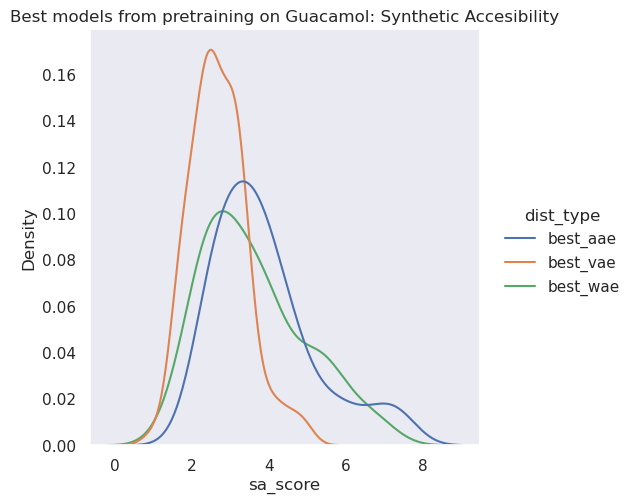

In [38]:
import seaborn as sns
sns.set_theme()
sns.set_style("dark")
sns.displot(df_guac ,x = 'sa_score',  hue="dist_type", kind = 'kde')
plt.title('Best models from pretraining on Guacamol: Synthetic Accesibility')
plt.savefig('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/plots/pretrain_guac_sa_all_model_combined.png', bbox_inches="tight")

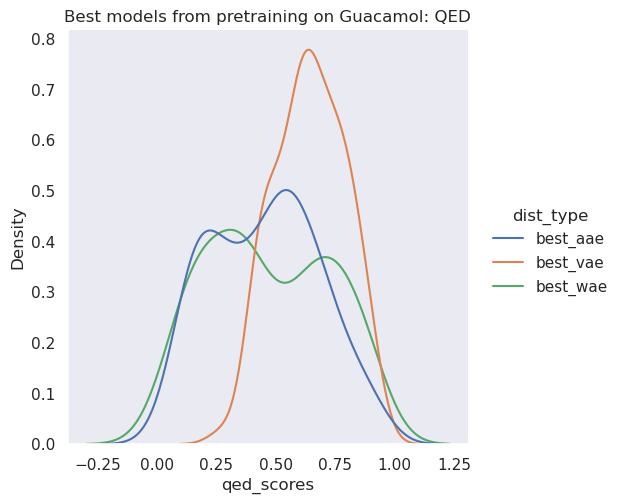

In [39]:
import seaborn as sns
sns.set_theme()
sns.set_style("dark")
sns.displot(df_guac ,x = 'qed_scores',  hue="dist_type", kind = 'kde')
plt.title('Best models from pretraining on Guacamol: QED')
plt.savefig('/data/ongh0068/l1000/FYP-DrugDiscoveryWithDeepLearning/plots/pretrain_guac_qed_all_model_combined.png', bbox_inches="tight")

In [41]:
df_guac.qed_scores.min()

0.011273582893666477

In [ ]:
import pandas as pd
dfs = []
for key in tmp:
    sa_scores = tmp[key]['sa_scores']
    qed_scores = tmp[key]['qed_scores']
    dist_type = [key.strip('.json') for _ in range(len(tmp[key]['sa_scores']))]
    df = pd.DataFrame([sa_scores, qed_scores, dist_type]).T
    df.columns = ['sa_score', 'qed_scores', 'dist_type']
    dfs.append(df)
    

In [ ]:
df_guac_sa_scores = pd.concat(dfs)